# Ratings and Reviews

This notebook explores how to make use of and visualize product ratings and reviews

In [41]:
%load_ext autoreload
%autoreload 

import pandas as pd
import matplotlib.pyplot as plt

import shared.viz as viz
import shared.query as q
import shared.format as format
import shared.reviews as rev

#viz.set_style()
conn = q.connect()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [43]:
text = 'Harry Potter'
category = 'Books'
product = q.find_products(category, text, conn).iloc[0]
product

find_products: 48 results in 0.290 seconds


id                                                     B000IEZE3G
reviews                                                      6711
title                       Harry Potter and The Sorcerer's Stone
creator                                             J. K. Rowling
publisher                                   Bloomsbury Publishing
description     Celebrate 20 years of Harry Potter magic! Harr...
release_date                                           2014-01-09
category                                                    Books
subcategory                                      Juvenile Fiction
Name: 0, dtype: object

## Ratings

Ratings are essential to Presto's recommendations - Presto finds similar products by looking only at ratings by various users.

To help return high-quality results quickly, Presto filters low-quality reviews based on users' helpful/unhelpful votes.

In [48]:
reviews = q.get_reviews(product.id, conn) # reviews include a rating
reviews[:2]

get_reviews: 6711 results in 0.063 seconds


,user_id,product_id,title,review,rating,upvotes,downvotes,timestamp
0,None,B000IEZE3G,"A great book, I couldn't stop reading it.","Famous before he can talk, Harry Potter the so...",5,0,0,926640000
1,None,B000IEZE3G,I believe this is the greatest book in history.,I believe this is the greatest book in history...,5,0,0,926640000


### Rating Quality

Presto can sort reviews by quality. The underlying algorithm pads each review's upvotes and downvotes by the average amount. This seems very effective at surfacing the most helpful and unhelpful reviews, as seen by the results below:

In [51]:
print("BEST + WORST REVIEWS:")
reviews_by_quality = rev.sort_reviews(reviews)
reviews_by_quality

BEST + WORST REVIEWS:


,user_id,product_id,title,review,rating,upvotes,downvotes,timestamp,quality
3004,A3IB1W0SVED0Z3,B000IEZE3G,A magical read&#65533;in more ways than one!,What a wonderful book! I read it after my 11-y...,5,45,2,959040000,11.895324
3008,A3KZC2TLRZLOA0,B000IEZE3G,Anniversary Edition nice but not essential.,"In today's economy, customers buying books nee...",5,45,3,1221523200,9.499265
3009,A2CQXJ7FPVJTYV,B000IEZE3G,Harry Potter and the Sorcerer's Stone (Book 1),"First of all, I am 52 years old. While I have ...",5,35,2,950054400,9.372961
3007,None,B000IEZE3G,Ages 9-12? Hah!,Harry Potter and the Sorceror's Stone is one o...,5,58,5,943056000,8.637968
3005,AYNKNXA92QMN1,B000IEZE3G,I want to go to Hogwarts!,"Granted, I lack the basic criterion for being ...",5,83,8,949190400,8.546253
...,...,...,...,...,...,...,...,...,...
5600,AVAG7ND5A1NZB,B000IEZE3G,Where is my purchase?,My item was supposed to be delivered to my dor...,1,0,21,1242432000,0.094034
5599,A1HO9JF4W4JFX5,B000IEZE3G,I'd be happier if it had arrived,This book has not arrived. I have written to t...,1,0,21,1246406400,0.094034
5598,A14I2NQ6EYV5Y9,B000IEZE3G,Copyright infringment????,This item was very unprofessional and I questi...,1,0,21,1249084800,0.094034
5602,A2UZI75GS91BMX,B000IEZE3G,LATE,I ordered this book about 25 days ago and it h...,1,0,22,1283040000,0.090110


Rating quality can have a surprisingly strong effect on overall ratings. Presto's product results filter unhelful reviews by default, which has an especially strong effect for very popular products while only sacrificing small volumes of reviews. Notice how the low ratings all but disappear after removing unhelpful reviews in this case:

RAW RATINGS:


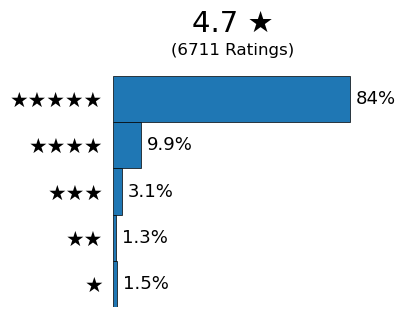

In [54]:
print('RAW RATINGS:')
fig = plt.figure(figsize = (3,3))
viz.plot_ratings(reviews_by_quality.rating, style = 'bars')

HELPFUL RATINGS:


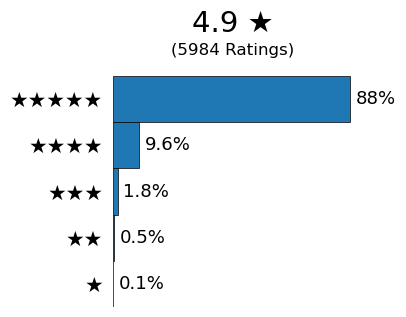

In [56]:
print("HELPFUL RATINGS:")
fig = plt.figure(figsize = (3,3))
viz.plot_ratings(reviews_by_quality[reviews_by_quality.quality > 1].rating, style = 'bars')

### Rating Visualization

Ratings are an excellent example of why we can rarely rely on matplotlib defaults to achieve presentable user-facing results:

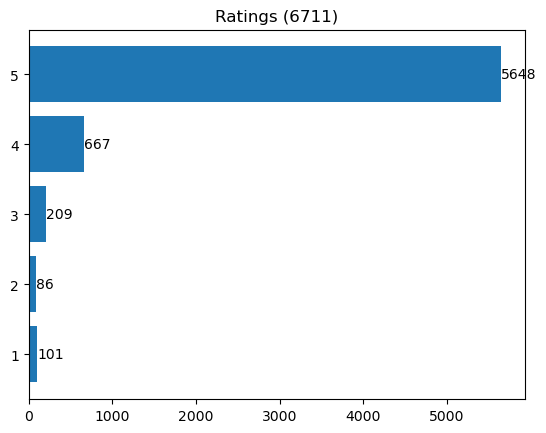

In [59]:
rating_counts = reviews.rating.value_counts()
bars = plt.barh(rating_counts.index, rating_counts.values)
plt.bar_label(bars, rating_counts)
plt.title(f'Ratings ({len(reviews)})');
plt.savefig('../images/ratings-matplotlib.png')

Instead, Presto uses a reusable data viz component to style ratings.

We could also use our percent-based bar utility instead:

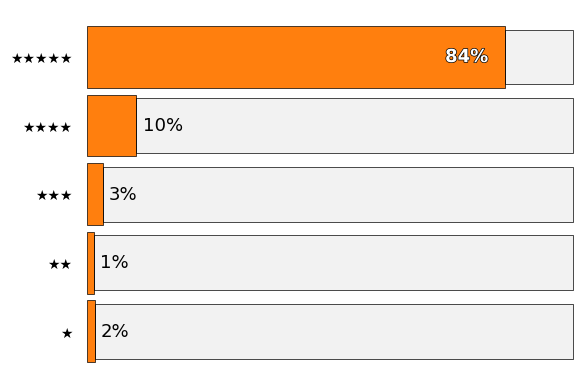

In [64]:
reviews_norm = reviews.rating.value_counts(normalize = True)
viz.plot_rates(reviews_norm.index, reviews_norm, color = 'C1')
plt.gca().set(
    yticks = range(1,6),
    yticklabels = ['★' * x for x in range(1,6)],
    xticks = []
)
plt.gca().spines['bottom'].set_visible(False)

This looks quite good, actually. Let's integrate it into the rating widget and make it the new default:

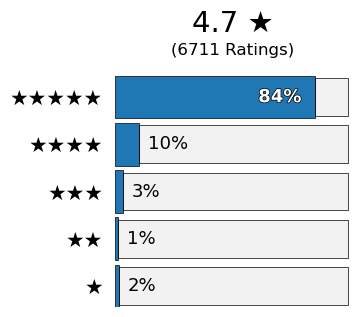

In [78]:
fig = plt.figure(figsize = (3,3))
viz.plot_ratings(reviews.rating)
plt.savefig('../images/ratings-percentbar.png', bbox_inches = 'tight')

## Reviews

In [20]:
print('Best reviews:\n\n')
reviews_by_quality[:10][['title', 'review', 'quality']]

Best reviews:




,title,review,quality
3004,A magical read&#65533;in more ways than one!,What a wonderful book! I read it after my 11-y...,11.895324
3008,Anniversary Edition nice but not essential.,"In today's economy, customers buying books nee...",9.499265
3009,Harry Potter and the Sorcerer's Stone (Book 1),"First of all, I am 52 years old. While I have ...",9.372961
3007,Ages 9-12? Hah!,Harry Potter and the Sorceror's Stone is one o...,8.637968
3005,I want to go to Hogwarts!,"Granted, I lack the basic criterion for being ...",8.546253
3001,Magnificiant,"Now and then, A book comes along that makes pe...",8.318174
3000,Our first foray into Potter's world is truly m...,With this introductory novel was published in ...,8.280273
3002,Three Harry Potter Books in Three Days!,An adult friend (age 49)loaned me three Harry ...,8.029614
4943,Harry Potter and the Sorcerer's Stone,Harry Potter and the Sorcerer's Stone by J.K. ...,7.207524
4940,Can I Even Begin with them?,When I first picked up this book it was the ch...,7.207524


In [21]:
print('Worst reviews:\n\n')
reviews_by_quality[-10:][['title', 'review', 'quality']]

Worst reviews:




,title,review,quality
4852,Dont read,I don't think that you should read this book b...,0.109080
5777,Not at all like described--bait and switch,I ordered two of these books. I was quite surp...,0.108164
5776,Smell,Book came with weird smell and didn't include ...,0.108164
4835,I didn't received this book just now.,"Hi,I did't received this item just now.I would...",0.098315
4834,I don't understand why Henry Potter is so popular,"I mean, what's so exciting about witches, or a...",0.098315
5600,Where is my purchase?,My item was supposed to be delivered to my dor...,0.094034
5599,I'd be happier if it had arrived,This book has not arrived. I have written to t...,0.094034
5598,Copyright infringment????,This item was very unprofessional and I questi...,0.094034
5602,LATE,I ordered this book about 25 days ago and it h...,0.090110
403,not impressed,"I picked this book up (from my kids) because, ...",0.083221


In [22]:
print("Best review:\n\n")
print(reviews_by_quality.iloc[0].review.replace('.', '.\n'))

Best review:


What a wonderful book! I read it after my 11-year old son suggested it as a change from my usual reading fare of history and biography.
 It turned out to be much more than just a springtime reading diversion.
.
.
it became for me a &quot;magical&quot; reading experience in more ways than one.
 I was quickly captivated by Harry, Hagrid, Dumbledore, Hermoine, and yes, even the nasty Dursleys, Snape, and Draco Mafoy.
 Hogwarts came to life for me.
 I found myself unable to put the book down because it was so exciting and much fun to read! It's easy to understand why my son (and so many kids just like him) love Harry Potter so much.
J.
K.
 Rowling proves herself a gifted writer of children's books, not only because the plot is good and the characters come to life, but also because her writing fires the imagination and teaches positive values.
&quot;Harry Potter and the Sorcerer's Stone&quot; is a great book for kids of all ages.
.
.
from 9 to 99.
 It's destined to be a class

In [23]:
print("Worst review:\n\n")
print(reviews_by_quality.iloc[-1].review.replace('.', '.\n'))

Worst review:


I picked this book up (from my kids) because, while reading reviews of the Twilight Saga, it was constantly being compared (unfairly, in my opinion) to HP.
 I have seen and LOVED all the HP movies, and consider myself an HP fan, but, this first book is a major disappointment.
I was expecting much better writing, more descriptive story telling and better characters.
 I am not finished with the book yet, and I will finish it, but I am not too sure I will finish the series.
To be fair, my 10 year old did tell me it was kinda boring, but he has read it 3 times.
.
.
 maybe I need to introduce him to the rest of my library! It has some fabulous fantasy in it.
 MUCH better than this.
This is the rare case where the movies are FAR superior to the books.



## Future Enhancements

Conducting **natural language processing** on user reviews could be a great way to enhance a product recommendation page. What high-sentiment adjectives are users using to describe this product? What other artists or products are reviewers mentioning? Etc.

While this was a goal for the original vision of Presto, the data-intensive nature of the project warranted a shift to focus on how to design and develop a performant SQL architecture for products and reviews instead.

## Close Connection

In [26]:
conn.close()